In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -q spacy

In [ ]:
!pip install -q tensorflow

In [ ]:
!pip install -q transformers

In [ ]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [ ]:
# Imports
import math
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers.experimental import Adam
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## LSTM (Long Short-Term Memory)

Usaremos os dados processados com SpaCy e então faremos o processamento específico para o modelo LSTM, assim como fizemos com o modelo da versão 1.

In [ ]:
# Dados processados com SpaCy
dados_dsa_treino.head()

,texto,sentimento,texto_processado
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [ ]:
# Criação do tokenizador
# from keras.preprocessing.text import Tokenizer
dsa_tokenizador = Tokenizer()

In [ ]:
# Ajuste do tokenizador com os textos processados
dsa_tokenizador.fit_on_texts(dados_dsa_treino['texto_processado'])

In [ ]:
# Extrai o índice de palavras
word_index = dsa_tokenizador.word_index

In [ ]:
len(word_index)

11897

In [ ]:
# Itera sobre os pares chave-valor do dicionário
for i, (chave, valor) in enumerate(word_index.items()):
    print(chave, valor)
    # Interrompe o loop após imprimir 10 itens
    if i == 9:
        break

feel 1
like 2
m 3
not 4
feeling 5
know 6
time 7
t 8
want 9
think 10


In [ ]:
# Conversão dos textos de treino para sequências de tokens
sequencias_treino = dsa_tokenizador.texts_to_sequences(dados_dsa_treino['texto_processado'])

In [ ]:
# Definindo o comprimento máximo das sequências
max_length = 100

In [ ]:
# Padding das sequências de treino
sequencias_treino_padded = pad_sequences(sequencias_treino, maxlen = max_length, truncating = 'post')

O "padding" é uma técnica comumente usada no processamento de sequências de dados, especialmente em tarefas de processamento de linguagem natural (PLN). O padding é usado para padronizar o comprimento das sequências. Isso é feito adicionando um valor especial (geralmente 0) no início ou no final das sequências para aumentá-las até um comprimento máximo definido. Isso permite que o modelo processe lotes de sequências simultaneamente, o que é essencial para a eficiência do treinamento.

Na linha acima:

**maxlen = max_length**: Este argumento define o comprimento máximo das sequências após o padding. Se uma sequência for mais curta que max_length, ela será estendida com zeros até alcançar esse comprimento. Se for mais longa, será truncada.

**truncating = 'post'**: Este argumento especifica como as sequências devem ser truncadas para o comprimento máximo, caso sejam mais longas que max_length. O valor 'post' indica que o truncamento deve ocorrer no final da sequência. Alternativamente, 'pre' truncaria no início.

O resultado, sequencias_treino_padded, será uma matriz onde cada sequência tem exatamente max_length elementos, com padding de zeros adicionado conforme necessário. Isso torna as sequências compatíveis com muitos modelos de aprendizado de máquina, especialmente aqueles usados em PLN.

In [ ]:
# Conversão dos textos de teste para sequências de tokens
sequencias_teste = dsa_tokenizador.texts_to_sequences(dados_dsa_teste['texto_processado'])

In [ ]:
# Padding das sequências de teste
sequencias_teste_padded = pad_sequences(sequencias_teste, maxlen = max_length)

In [ ]:
# Criação do codificador de rótulos
dsa_le_v2 = LabelEncoder()

In [ ]:
# Fit e transform dos rótulos de sentimento para treino
y_treino_le = dsa_le_v2.fit_transform(dados_dsa_treino['sentimento'])

In [ ]:
# Transformação dos rótulos de sentimento para teste
y_teste_le = dsa_le_v2.transform(dados_dsa_teste['sentimento'])

In [ ]:
# Conversão dos rótulos em variáveis categóricas
y_treino_encoded = to_categorical(y_treino_le)
y_teste_encoded = to_categorical(y_teste_le)

In [ ]:
# Definindo o tamanho do vocabulário
vocab_size = len(dsa_tokenizador.word_index) + 1

In [ ]:
print(vocab_size)

11898


In [ ]:
# Definindo a dimensão do embedding
embedding_dim = max_length

In [ ]:
# Construção do modelo LSTM
modelo_dsa_v2 = tf.keras.Sequential([Embedding(vocab_size, embedding_dim, input_length = max_length),
                                     Bidirectional(LSTM(64)),
                                     Dropout(0.4),
                                     Dense(32, activation = 'leaky_relu', kernel_regularizer = 'l1_l2'),
                                     Dropout(0.4),
                                     Dense(6, activation = 'softmax')])

In [ ]:
# Compilação do modelo
modelo_dsa_v2.compile(loss = 'categorical_crossentropy',
                      optimizer = 'adam',
                      metrics = ['accuracy', Precision(), Recall(), AUC()])

In [ ]:
# Exibindo o resumo do modelo
print(modelo_dsa_v2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1189800   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 6)                 198       
                                                      

In [ ]:
# Definindo os dados de entrada como array
dados_entrada = np.array(sequencias_treino_padded)

In [ ]:
# Definindo os dados de saída como array
dados_saida = np.array(y_treino_encoded)

In [ ]:
# Definição de hiperparâmetros
num_epochs = 35
validation_split_value = 0.2
paciencia = 5

In [ ]:
# Configuração de Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience = paciencia)

> Treinamento do Modelo.

In [ ]:
%%time
history = modelo_dsa_v2.fit(dados_entrada,
                            dados_saida,
                            epochs = num_epochs,
                            verbose = 1,
                            validation_split = validation_split_value,
                            callbacks = [early_stopping])

Epoch 1/35
400/400 [==============================] - 27s 55ms/step - loss: 2.4435 - accuracy: 0.3224 - precision_1: 0.4444 - recall_1: 6.2500e-04 - auc_1: 0.7029 - val_loss: 1.6211 - val_accuracy: 0.3262 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.7234
Epoch 2/35
400/400 [==============================] - 8s 20ms/step - loss: 1.4613 - accuracy: 0.3617 - precision_1: 0.5007 - recall_1: 0.0845 - auc_1: 0.7969 - val_loss: 1.2953 - val_accuracy: 0.4238 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.8471
Epoch 3/35
400/400 [==============================] - 6s 14ms/step - loss: 1.2316 - accuracy: 0.4306 - precision_1: 0.5146 - recall_1: 0.1839 - auc_1: 0.8611 - val_loss: 1.2199 - val_accuracy: 0.4247 - val_precision_1: 0.5660 - val_recall_1: 0.1541 - val_auc_1: 0.8618
Epoch 4/35
400/400 [==============================] - 6s 16ms/step - loss: 1.1348 - accuracy: 0.4531 - precision_1: 0.5380 - recall_1: 0.2321 - auc_1: 0.8764 - val_loss: 1.

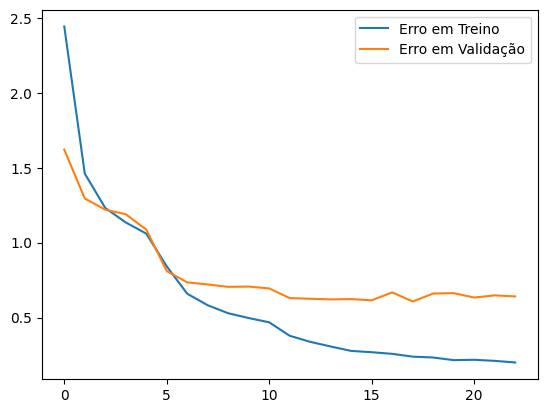

In [ ]:
# Plot das curvas de erro
loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(loss, label = 'Erro em Treino')
plt.plot(val_loss, label = 'Erro em Validação')
plt.legend()
plt.show()

In [ ]:
# Previsões com dados de teste
previsoes = modelo_dsa_v2.predict(sequencias_teste_padded)

63/63 [==============================] - 1s 6ms/step


In [ ]:
# Determinação dos rótulos previstos
labels_previstos = previsoes.argmax(axis = 1)

In [ ]:
# Exibição do relatório de classificação
print(classification_report(y_teste_le, labels_previstos))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       275
           1       0.87      0.86      0.86       224
           2       0.91      0.92      0.91       695
           3       0.73      0.73      0.73       159
           4       0.92      0.94      0.93       581
           5       0.74      0.70      0.72        66

    accuracy                           0.89      2000
   macro avg       0.85      0.83      0.84      2000
weighted avg       0.89      0.89      0.89      2000



In [ ]:
# Exibição da matriz de confusão
print(confusion_matrix(y_teste_le, labels_previstos))

[[237   8   9   3  18   0]
 [ 12 193   3   1   6   9]
 [  1   2 637  34  15   6]
 [  1   3  31 116   7   1]
 [ 10   7  14   4 546   0]
 [  1  10   7   1   1  46]]


In [ ]:
# Exibição da precisão do modelo
print(accuracy_score(y_teste_le, labels_previstos))

0.8875


In [ ]:
# Salva o modelo
modelo_dsa_v2.save('modelo_dsa_v2.keras')

> Deploy do Modelo.

In [ ]:
# Carrega o modelo salvo
modelo_carregado = load_model('modelo_dsa_v2.keras')

In [ ]:
# Nova frase (sentimento = medo (fear))
frase = "i even feel a little shaky"

In [ ]:
# Cria um dataframe com a frase
df_novo = pd.DataFrame({'Frase': [frase]})

In [ ]:
# Aplica a função de processamento
df_novo['Frase_Processada'] = df_novo['Frase'].apply(dsa_preprocessa_texto)

In [ ]:
# Processar os novos dados
sequencias_novos = dsa_tokenizador.texts_to_sequences(df_novo['Frase_Processada'])
sequencias_novos_padded = pad_sequences(sequencias_novos, maxlen = max_length)

In [ ]:
# Fazer previsões com o modelo carregado
previsoes = modelo_carregado.predict(sequencias_novos_padded)

1/1 [==============================] - 1s 901ms/step


In [ ]:
# Seleciona a classe com maior probabilidade
classe_maior_prob = np.argmax(previsoes, axis = 1)

In [ ]:
classe_maior_prob

array([1])

In [ ]:
# Obtém o nome da classe
nome_classe = dsa_le_v2.inverse_transform(classe_maior_prob)

In [ ]:
# Classe prevista
nome_classe

array(['fear'], dtype=object)